In [ ]:
!pip install -q tf-nightly

     |████████████████████████████████| 325.3MB 45kB/s 
     |████████████████████████████████| 13.1MB 51.2MB/s 
     |████████████████████████████████| 460kB 52.2MB/s 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import cv2
import time

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
!ln -s /content/drive/My\ Drive/ /mydrive
!ls /mydrive

 10475173_519578228169632_118673997_n.jpg
 12.JPG
 13551561_1604818646495938_1838992123_n.jpg
 14574130_229761800806500_4951989114946715648_n.jpg
 1519145662662.jpg
 1520023663376.jpg
 15275561_1223182561097846_5547455789024673792_n.jpg
'20180219_123900(0).jpg'
 3_1427957373.jpg
 3300_prabhas.jpg
 381248_281440188580455_216325291758612_809519_1043277880_n-Copy-Copy.jpg
 498inverterlayout.jpg
 498nand2layout.jpg
 500038.csv
 500113.csv
 500209.csv
 500312.csv
 500325.csv
 500425.csv
 500470.csv
 500510.csv
 509099.jpg
 532174.csv
 532281.csv
 532648.csv
 532670.csv
 532822.csv
 533171.csv
 _565761458_orig.jpg
 5be53eb826070a0afa35c0b32373bc13.jpg
 600x600.jpg
 a47jyny_460s.jpg
 ACL-500425.xlsx
 ae-v2b.png
'Allahu Trapbar - Arabic - Trap - Beat - Compilation video.mp4'
 Aniket_SOP_USF.gdoc
 Aniket_SOP_USF.pdf
 An-oldie-but-certainly-a-goodie.jpg
 A-normal-day-in-India.jpg
 Anu20-min.jpg
 aoNpGMx_460s.jpg
 ap2LdY5_460s.jpg
 As-a-single-man-I-can-agree.jpg
 A-ticket-to-Hell-please.jpg
 avO

In [ ]:
!cp /mydrive/dataset/fire_dataset.zip ./

In [ ]:
!unzip fire_dataset.zip

Archive:  fire_dataset.zip
   creating: fire_dataset/
   creating: fire_dataset/train/
   creating: fire_dataset/train/fire_images/
  inflating: fire_dataset/train/fire_images/fire.1.png  
  inflating: fire_dataset/train/fire_images/fire.10.png  
  inflating: fire_dataset/train/fire_images/fire.100.png  
  inflating: fire_dataset/train/fire_images/fire.101.png  
  inflating: fire_dataset/train/fire_images/fire.102.png  
  inflating: fire_dataset/train/fire_images/fire.103.png  
  inflating: fire_dataset/train/fire_images/fire.104.png  
  inflating: fire_dataset/train/fire_images/fire.105.png  
  inflating: fire_dataset/train/fire_images/fire.106.png  
  inflating: fire_dataset/train/fire_images/fire.107.png  
  inflating: fire_dataset/train/fire_images/fire.108.png  
  inflating: fire_dataset/train/fire_images/fire.109.png  
  inflating: fire_dataset/train/fire_images/fire.11.png  
  inflating: fire_dataset/train/fire_images/fire.110.png  
  inflating: fire_dataset/train/fire_images/fi

In [ ]:
path_to_zip = '/content/fire_dataset.zip'
PATH = os.path.join(os.path.dirname(path_to_zip), 'fire_dataset')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 1552 files belonging to 2 classes.


In [ ]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 97 files belonging to 2 classes.


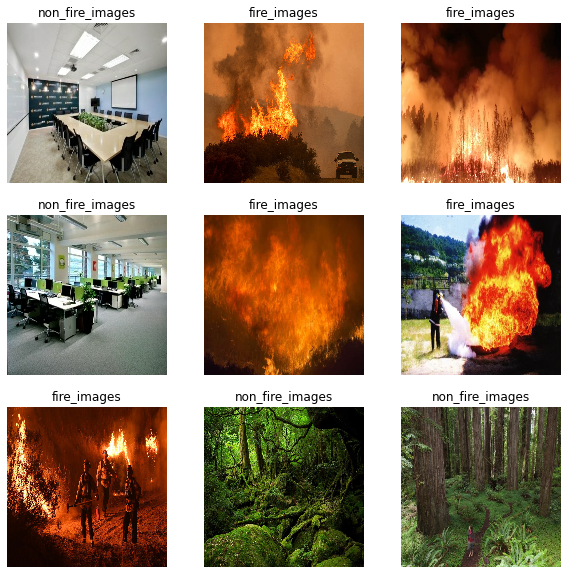

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 3)
validation_dataset = validation_dataset.skip(val_batches // 3)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 3
Number of test batches: 1


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

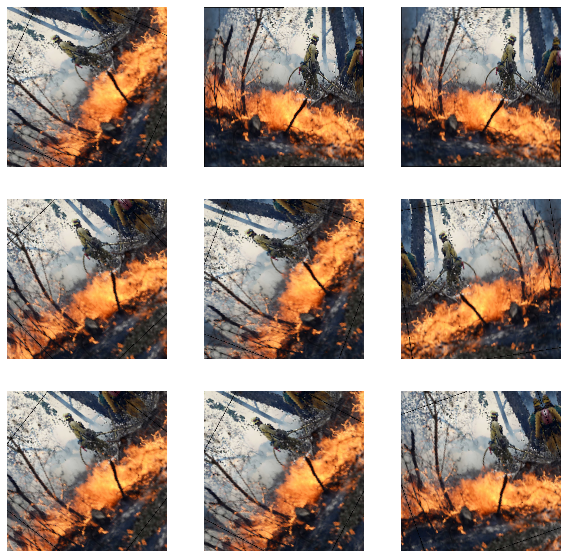

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)             

In [ ]:
len(model.trainable_variables)

2

In [ ]:
initial_epochs = 20

loss0, accuracy0 = model.evaluate(validation_dataset)

3/3 [==============================] - 3s 911ms/step - loss: 1.3912 - accuracy: 0.2441


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.35
initial accuracy: 0.26


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/20
49/49 [==============================] - 39s 795ms/step - loss: 1.0481 - accuracy: 0.4246 - val_loss: 0.6927 - val_accuracy: 0.7385
Epoch 2/20
49/49 [==============================] - 38s 773ms/step - loss: 0.7530 - accuracy: 0.5760 - val_loss: 0.5750 - val_accuracy: 0.7385
Epoch 3/20
49/49 [==============================] - 38s 766ms/step - loss: 0.6146 - accuracy: 0.6521 - val_loss: 0.4433 - val_accuracy: 0.7692
Epoch 4/20
49/49 [==============================] - 38s 770ms/step - loss: 0.4931 - accuracy: 0.7423 - val_loss: 0.3984 - val_accuracy: 0.7538
Epoch 5/20
49/49 [==============================] - 37s 756ms/step - loss: 0.4203 - accuracy: 0.7835 - val_loss: 0.3359 - val_accuracy: 0.8462
Epoch 6/20
49/49 [==============================] - 37s 748ms/step - loss: 0.3749 - accuracy: 0.8170 - val_loss: 0.2877 - val_accuracy: 0.8923
Epoch 7/20
49/49 [==============================] - 38s 771ms/step - loss: 0.3310 - accuracy: 0.8512 - val_loss: 0.2785 - val_accuracy: 0.8769

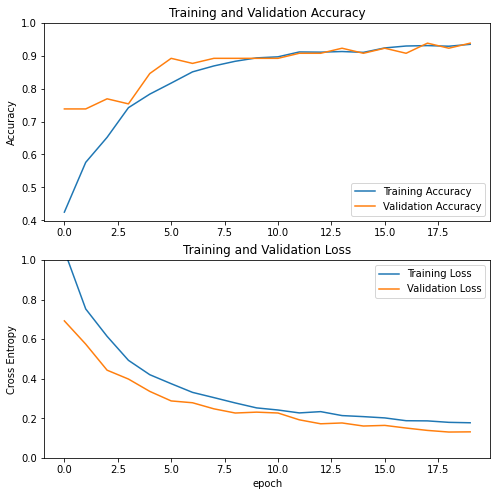

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)             

In [ ]:
len(model.trainable_variables)

56

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 20/30
49/49 [==============================] - 66s 1s/step - loss: 0.1600 - accuracy: 0.9400 - val_loss: 0.0756 - val_accuracy: 0.9846
Epoch 21/30
49/49 [==============================] - 57s 1s/step - loss: 0.1060 - accuracy: 0.9637 - val_loss: 0.0594 - val_accuracy: 0.9846
Epoch 22/30
49/49 [==============================] - 58s 1s/step - loss: 0.0993 - accuracy: 0.9627 - val_loss: 0.0348 - val_accuracy: 1.0000
Epoch 23/30
49/49 [==============================] - 57s 1s/step - loss: 0.0917 - accuracy: 0.9695 - val_loss: 0.0355 - val_accuracy: 0.9846
Epoch 24/30
49/49 [==============================] - 57s 1s/step - loss: 0.0815 - accuracy: 0.9712 - val_loss: 0.0522 - val_accuracy: 1.0000
Epoch 25/30
49/49 [==============================] - 58s 1s/step - loss: 0.0620 - accuracy: 0.9802 - val_loss: 0.0551 - val_accuracy: 0.9692
Epoch 26/30
49/49 [==============================] - 58s 1s/step - loss: 0.0627 - accuracy: 0.9808 - val_loss: 0.0574 - val_accuracy: 0.9846
Epoch 27/30
4

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

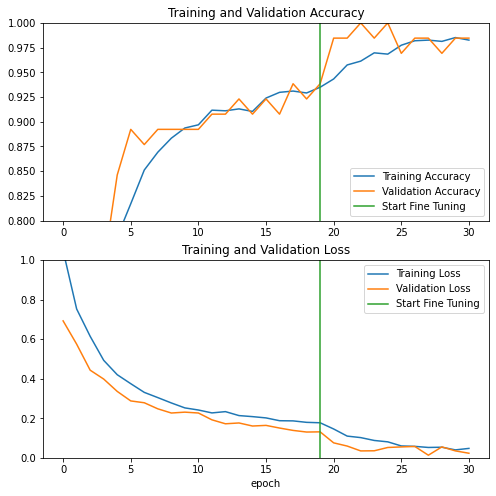

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

1/1 [==============================] - 1s 835ms/step - loss: 0.0396 - accuracy: 0.9688
Test accuracy : 0.96875


In [ ]:
!mkdir -p saved_model
tf.keras.models.save_model(
    model, 'saved_model/fire_detect_model', overwrite=True, include_optimizer=True, save_format=None,
    signatures=None, options=None
)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_model/fire_detect_model/assets


In [ ]:
!cp -r saved_model/ /mydrive/dataset/

In [ ]:
new_model = tf.keras.models.load_model('saved_model/fire_detect_model')
new_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)             

In [ ]:
import urllib.request

urllib.request.urlretrieve("https://s.w-x.co/in-uk1.jpg", "local.jpg")

test = cv2.imread('local.jpg')
test = cv2.resize(test,(160,160))
rgb = cv2.cvtColor(test,cv2.COLOR_BGR2RGB)
test2 = rgb[np.newaxis is None,:,:,:]

In [ ]:
test2.shape

(1, 160, 160, 3)

time taken 0.6741058826446533
Predictions:
 -7.310128


(-0.5, 159.5, 159.5, -0.5)

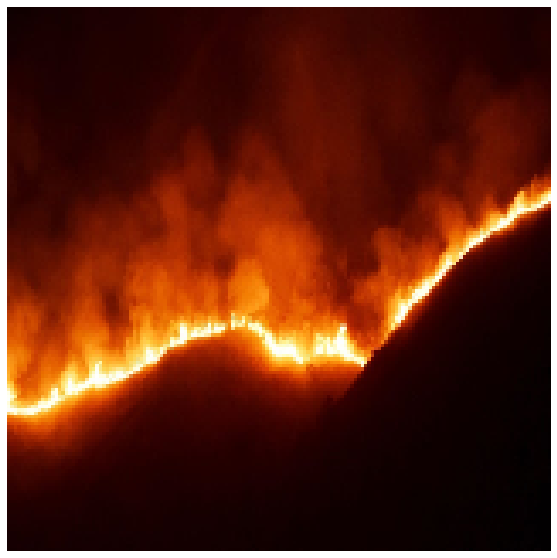

In [ ]:
start = time.time()
predictions = new_model.predict(test2)
end = time.time()
total = end-start
print("time taken {}".format(total))


print('Predictions:\n', predictions[0][0])

plt.figure(figsize=(10, 10))

plt.imshow(rgb)

plt.axis("off")